## Scanpy `pbmc4k`

In [3]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pylab as plt

In [43]:
results_out_root = '/home/jupyter/data/10x/out/'
marker_genes_txt = '/home/jupyter/data/10x/pbmc_marker_genes.txt'

rsem_pbmc_ss2_path = '/home/jupyter/data/ss2/RSEM.TPM.SM2.pbmc1.txt'
output_prefix = 'pbmc_ss2'

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = os.path.join(results_out_root, f'{output_prefix}.h5ad')

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.2 scipy==1.3.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [44]:
sc.settings.set_figure_params(dpi=80)

In [45]:
# load pbmc ss2 data
tpms_list = []
ss2_gene_names_list = []
with open(rsem_pbmc_ss2_path, 'r') as f:
    ss2_cell_names = f.readline().strip().split('\t')
    for line in f:
        toks = line.strip().split('\t')
        gene_name = toks[0]
        tpms = [float(x) for x in toks[1:]]
        ss2_gene_names_list.append(gene_name[16:])
        tpms_list.append(tpms)
pbmc_ss2_tpm_array = np.asarray(tpms_list).T

In [46]:
meta_pd = pd.read_csv('/home/jupyter/data/10x/meta.txt', sep='\t')
meta__names = meta_pd['NAME'].values.tolist()
meta__cell_types = meta_pd['CellType'].values.tolist()
ann_cell_names = [x[10:] for x in meta__names[1:253]]
ann_cell_types = [x for x in meta__cell_types[1:253]]

In [47]:
cell_keep_indices = [ss2_cell_names.index(cell_name) for cell_name in ann_cell_names]

In [48]:
import pandas as pd
adata = anndata.AnnData(pbmc_ss2_tpm_array[cell_keep_indices, :])
adata.var_names = anndata.utils.make_index_unique(pd.Index(ss2_gene_names_list))
adata.var['gene_ids'] = ss2_gene_names_list
adata.obs_names = pd.Index(ann_cell_names, name=0)

In [49]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

## Load marker genes

In [50]:
from collections import defaultdict
marker_genes_dict = defaultdict(list)

with open(marker_genes_txt, 'r') as f:
    while True:
        cluster_name = f.readline().strip()
        gene_name = f.readline().strip()
        sense = f.readline().strip()
        if sense == '+':
            sense = 1
        else:
            sense = -1
        if cluster_name == "":
            break
        marker_genes_dict[cluster_name].append((gene_name, sense))
        
all_marker_genes = []
for v in marker_genes_dict.values():
    all_marker_genes += [x[0] for x in v]
all_marker_genes = np.unique(all_marker_genes).tolist()

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


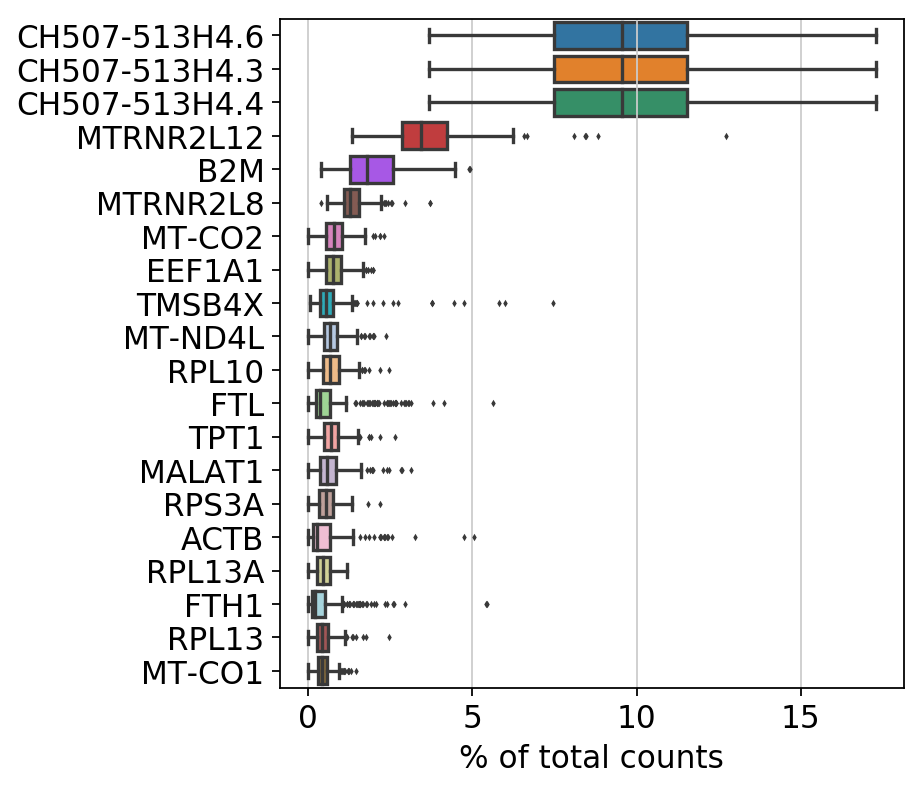

In [51]:
sc.pl.highest_expr_genes(adata, n_top=20, save="_" + output_prefix + '.pdf')

In [52]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=1)

filtered out 12321 genes that are detectedin less than 1 cells


In [53]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'gene_ids' as categorical


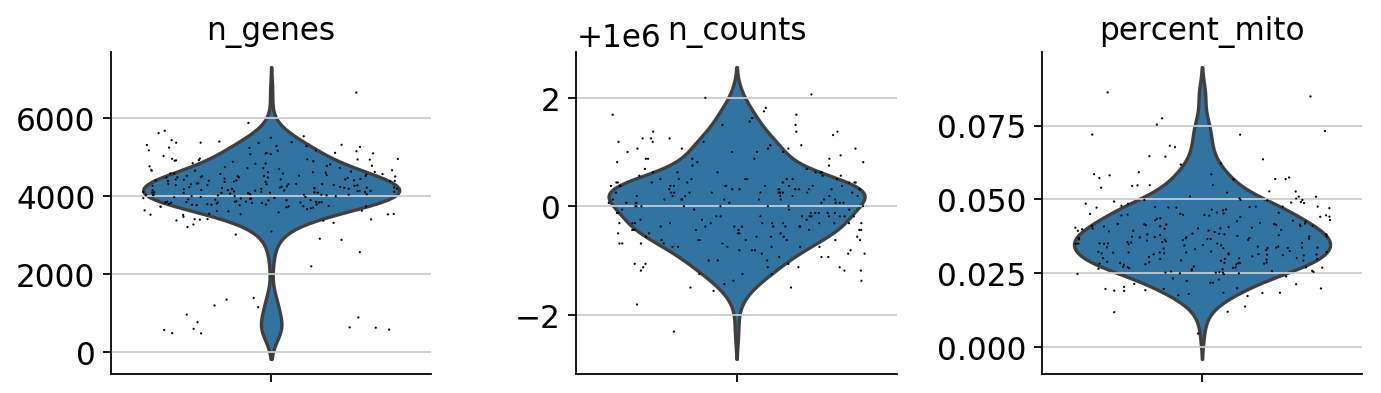

In [54]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

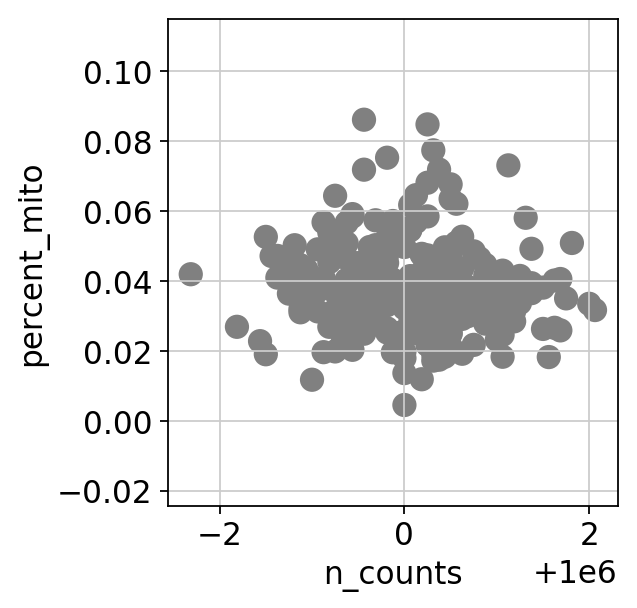

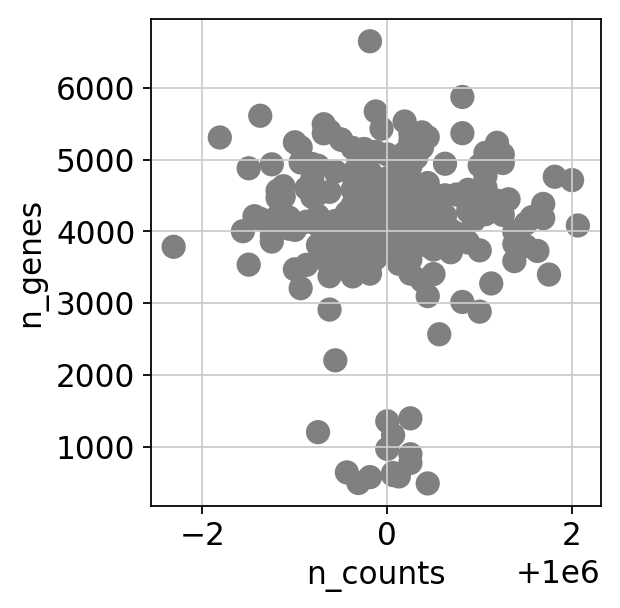

In [55]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [56]:
adata

AnnData object with n_obs × n_vars = 252 × 21373 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [57]:
# adata = adata[adata.obs['n_genes'] < 2500, :]
# adata = adata[adata.obs['percent_mito'] < 0.2, :]

In [58]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [59]:
sc.pp.log1p(adata)

In [60]:
adata.raw = adata
raw_gene_names = adata.var.index

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:116: RuntimeWarning: divide by zero encountered in true_divide
  ) / disp_std_bin[df['mean_bin'].values].values
/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:116: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_std_bin[df['mean_bin'].values].values


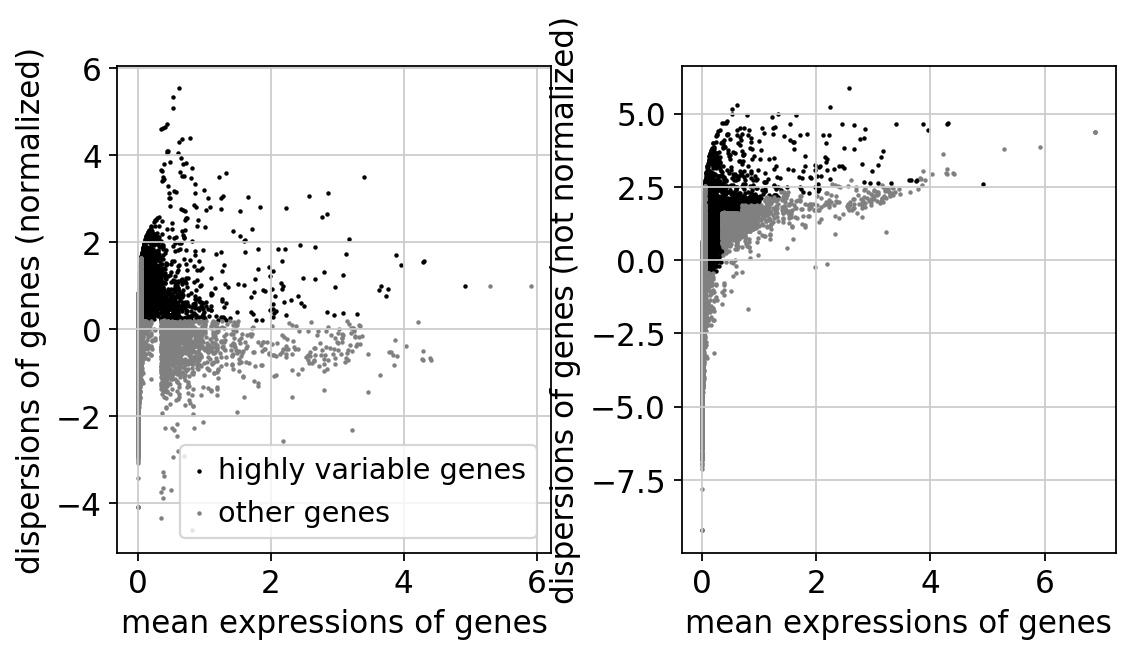

In [61]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=5, min_disp=0.2)
sc.pl.highly_variable_genes(adata)

In [62]:
# all_marker_genes_set = set(all_marker_genes)
# n = 0
# hvg_bool_list = []
# for gene_name in adata.var.index:
#     if gene_name in all_marker_genes_set:
#         hvg_bool_list.append(True)
#     else:
#         hvg_bool_list.append(False)
# adata.var['highly_variable'] = hvg_bool_list

In [63]:
adata = adata[:, adata.var['highly_variable']]

In [64]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    finished (0:00:17)


In [65]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

In [66]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=100)

computing PCA with n_comps = 100
computing PCA on highly variable genes
    finished (0:00:00)


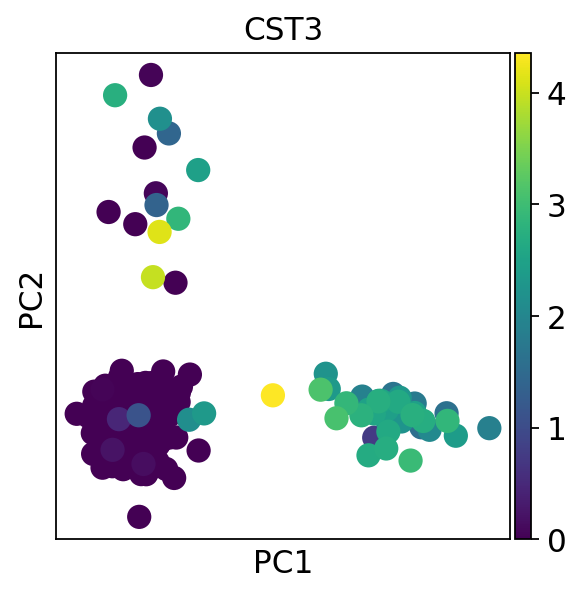

In [67]:
sc.pl.pca(adata, color='CST3')

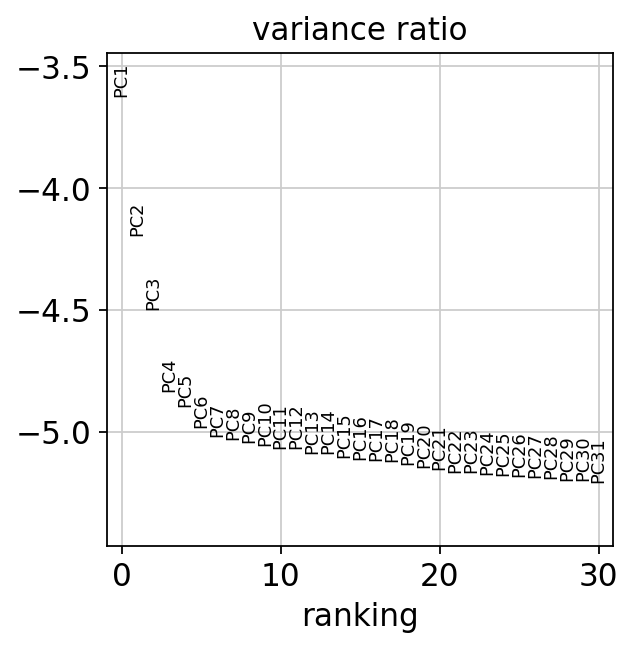

In [68]:
sc.pl.pca_variance_ratio(adata, log=True)

In [69]:
adata

AnnData object with n_obs × n_vars = 252 × 6169 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [70]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [71]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


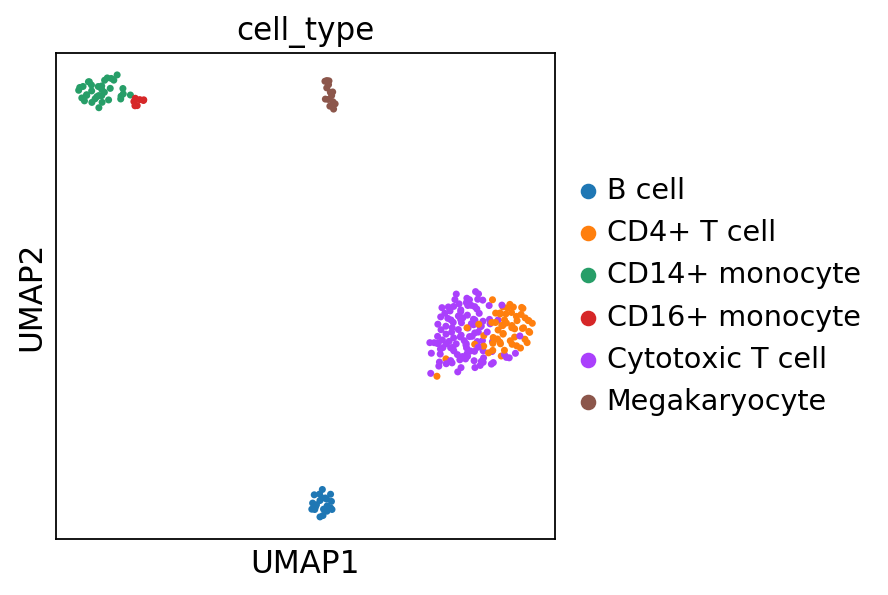

<Figure size 320x320 with 0 Axes>

In [79]:
import matplotlib.pylab as plt
sc.pl.umap(adata, color=['cell_type'], s=40, save="_" + output_prefix + '_big.pdf')
plt.tight_layout()

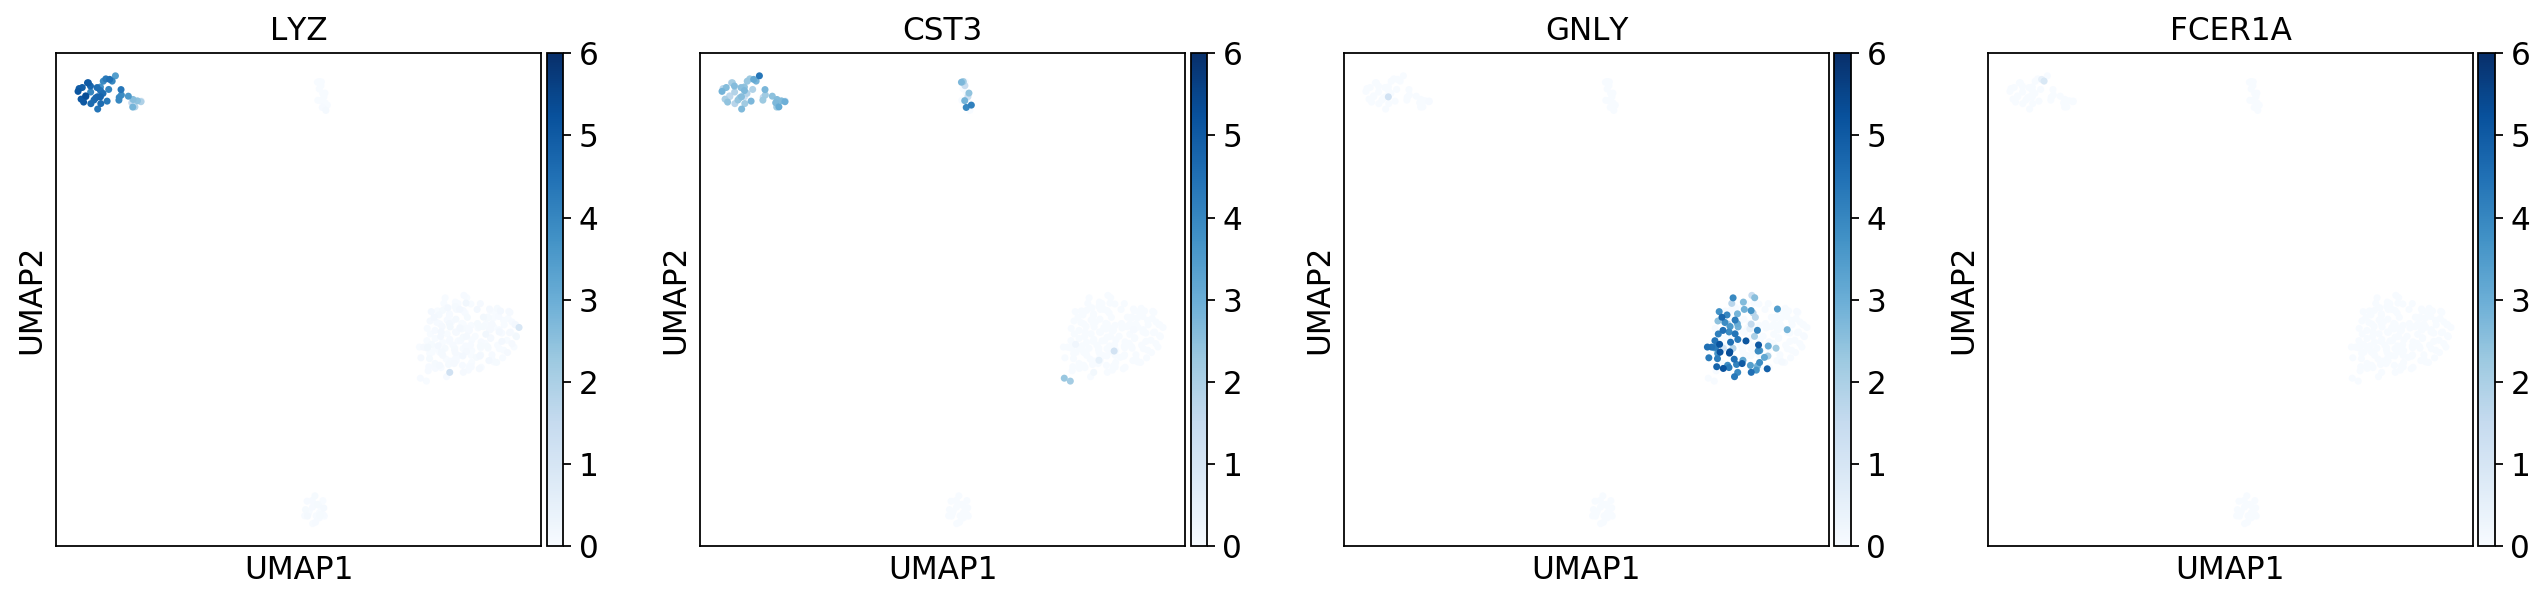

<Figure size 320x320 with 0 Axes>

In [80]:
import matplotlib.pylab as plt
sc.pl.umap(adata, color=['LYZ', 'CST3', 'GNLY', 'FCER1A'],
           color_map=plt.cm.Blues, s=40, vmax=6, save="_markers_" + output_prefix + '.pdf')
plt.tight_layout()

In [81]:
adata.write(results_file)

## Clustering

In [104]:
adata = sc.read(results_file)

In [105]:
# raw -> 0.7
# dtm -> 1.0
louvain_resolution = 1.0
sc.tl.louvain(adata, resolution=louvain_resolution)

if 'cell_type' in adata.obs.columns:
    adata.obs = adata.obs.drop(columns=['cell_type'])
adata.obs.insert(len(adata.obs.columns), 'cell_type', adata.obs['louvain'].values.tolist())

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [106]:
considered_cell_types = list(set(set(ann_cell_types)))
# considered_cell_types = list(marker_genes_dict.keys())
print(considered_cell_types)

['CD4+ T cell', 'Cytotoxic T cell', 'B cell', 'Megakaryocyte', 'CD16+ monocyte', 'CD14+ monocyte']


In [107]:
# max_cluster_index = max([int(x) for x in adata.obs['louvain'].values.tolist()])
# score_matrix = np.zeros((max_cluster_index + 1, len(considered_cell_types)))
# for cluster_index in range(max_cluster_index + 1):
#     print(cluster_index)
#     cluster_adata = adata[adata.obs['louvain'] == str(cluster_index), :]
#     for cell_type_index, cell_type in enumerate(considered_cell_types):
#         cell_type_ann = marker_genes_dict[cell_type]
#         score = 0.
#         n = 0.
#         for gene_name, sense in cell_type_ann:
#             try:
#                 score += np.sum(cluster_adata[:, gene_name].X * sense).item()
#                 n += 1
#             except:
#                 pass
#         score_matrix[cluster_index, cell_type_index] = score 

In [108]:
# cell_type_assignment = np.argmax(score_matrix, -1)
# for i, v in enumerate(adata.obs['louvain'].values):
#     adata.obs['cell_type'].values[i] = considered_cell_types[cell_type_assignment[int(v)]]

In [109]:
for i in range(len(adata.obs['cell_type'].values)):
    adata.obs['cell_type'].values[i] = ann_cell_types[i]

... storing 'cell_type' as categorical


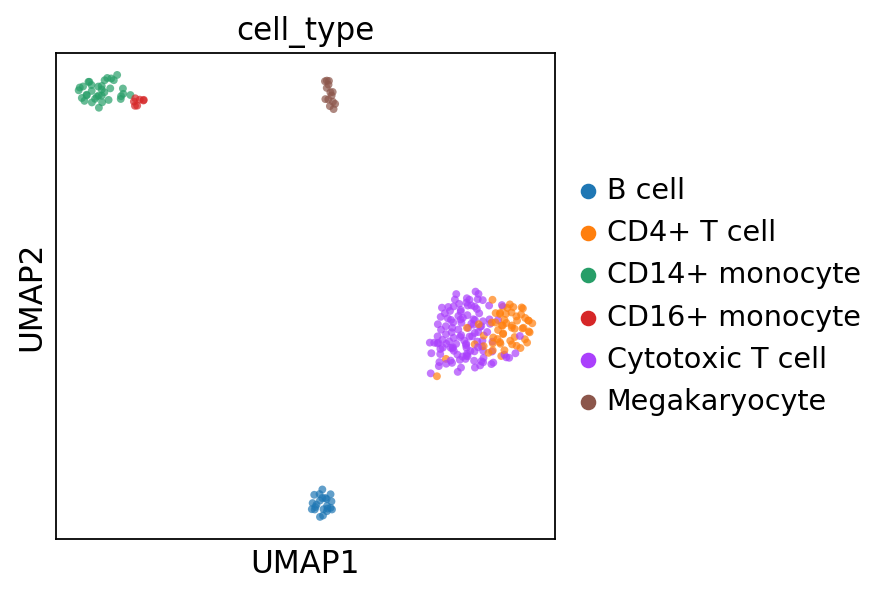

<Figure size 320x320 with 0 Axes>

In [110]:
import matplotlib.pylab as plt
sc.pl.umap(adata, color=['cell_type'], alpha=0.7, s=50, save="_" + output_prefix + '.pdf')
plt.tight_layout()

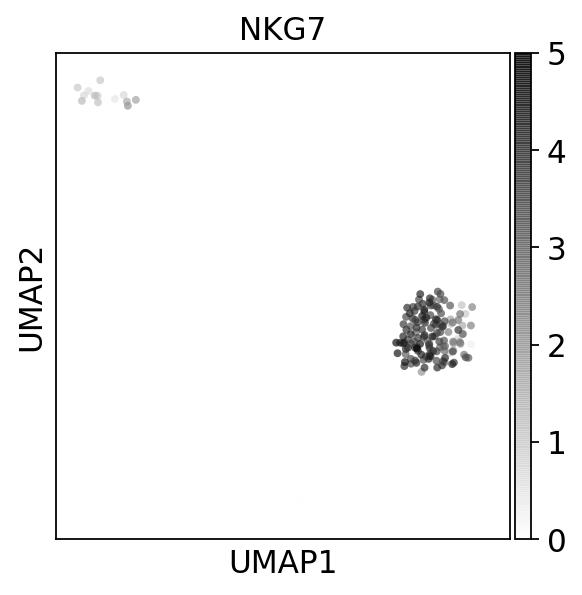

In [112]:
import matplotlib.pylab as plt

gene_name = 'NKG7'
batch_index = 0

sc.pl.umap(adata,
           color=gene_name,
           color_map=plt.cm.binary,
           use_raw=True,
           save="_" + gene_name + "_SS2_" + str(batch_index) + '.pdf',
           alpha=0.7, s=50,
           vmin=0, vmax=5)

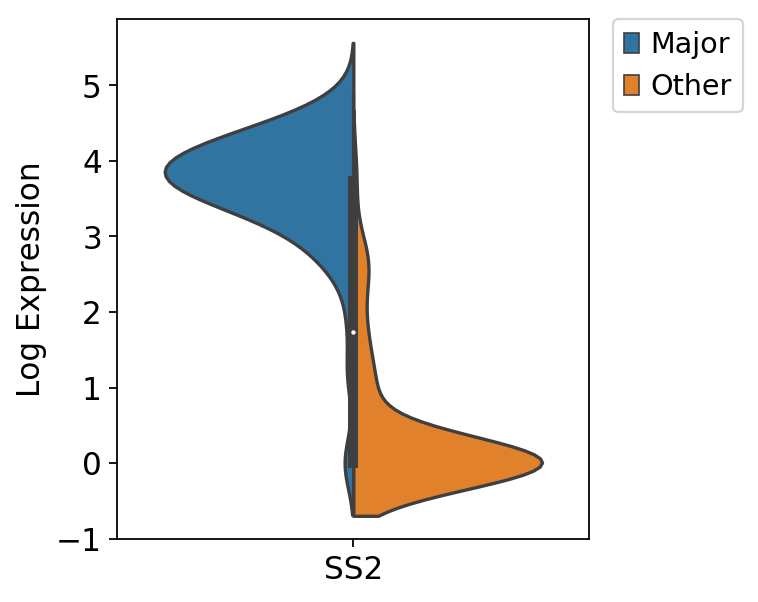

In [113]:
import seaborn as sns

gene_name = 'NKG7'
cell_types = {'Natural killer cell', 'Cytotoxic T cell'}
inc_group_name = "Major"
exc_group_name = "Other"

# gene_name = 'CST3'
# cell_types = {'Plasmacytoid dendritic cell', 'Megakaryoctye', 'CD14+ monocyte', 'CD16+ monocyte'}
# inc_group_name = "Major"
# exc_group_name = "Other"

# gene_name = 'LYZ'
# cell_types = {'Megakaryoctye', 'CD14+ monocyte', 'CD16+ monocyte'}
# inc_group_name = "Major"
# exc_group_name = "Other"

include_mask = None
exclude_mask = None

for cell_type in cell_types:
    if include_mask is None:
        include_mask = adata.obs['cell_type'] == cell_type
    else:
        include_mask = include_mask | (adata.obs['cell_type'] == cell_type)

for cell_type in cell_types:
    if exclude_mask is None:
        exclude_mask = adata.obs['cell_type'] != cell_type
    else:
        exclude_mask = exclude_mask & (adata.obs['cell_type'] != cell_type)

include_log1p_data = []
exclude_log1p_data = []
include_log1p_data.append(
    np.asarray(adata[include_mask, :].raw.X[
        :, raw_gene_names.tolist().index(gene_name)]).flatten())
exclude_log1p_data.append(
    np.asarray(adata[exclude_mask, :].raw.X[
        :, raw_gene_names.tolist().index(gene_name)]).flatten())

batch_data = []
group_data = []
expr_data = []

batch_name = 'SS2'
for expr in include_log1p_data[batch_index]:
    batch_data.append(batch_name)
    group_data.append(inc_group_name)
    expr_data.append(expr)
for expr in exclude_log1p_data[batch_index]:
    batch_data.append(batch_name)
    group_data.append(exc_group_name)
    expr_data.append(expr)
        
df = pd.DataFrame(
    data=np.asarray([batch_data, group_data, expr_data]).T,
    columns=["Depth", "Type", "Log Expression"]).astype(
    {"Depth": str, "Type": str, "Log Expression": float})


fig = plt.figure(figsize=(5, 4))
ax = sns.violinplot(
    x="Depth", y="Log Expression", hue="Type",
    data=df, scale='width', split=True,
    hue_order=['Major', 'Other'],
    order=['SS2'], bw=0.4)
ax.grid(False)
ax.legend_.remove()
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(f'/home/jupyter/CellBender/proto/chimera/notebooks/figures/violinplot_ss2_{gene_name}.pdf')

## Marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


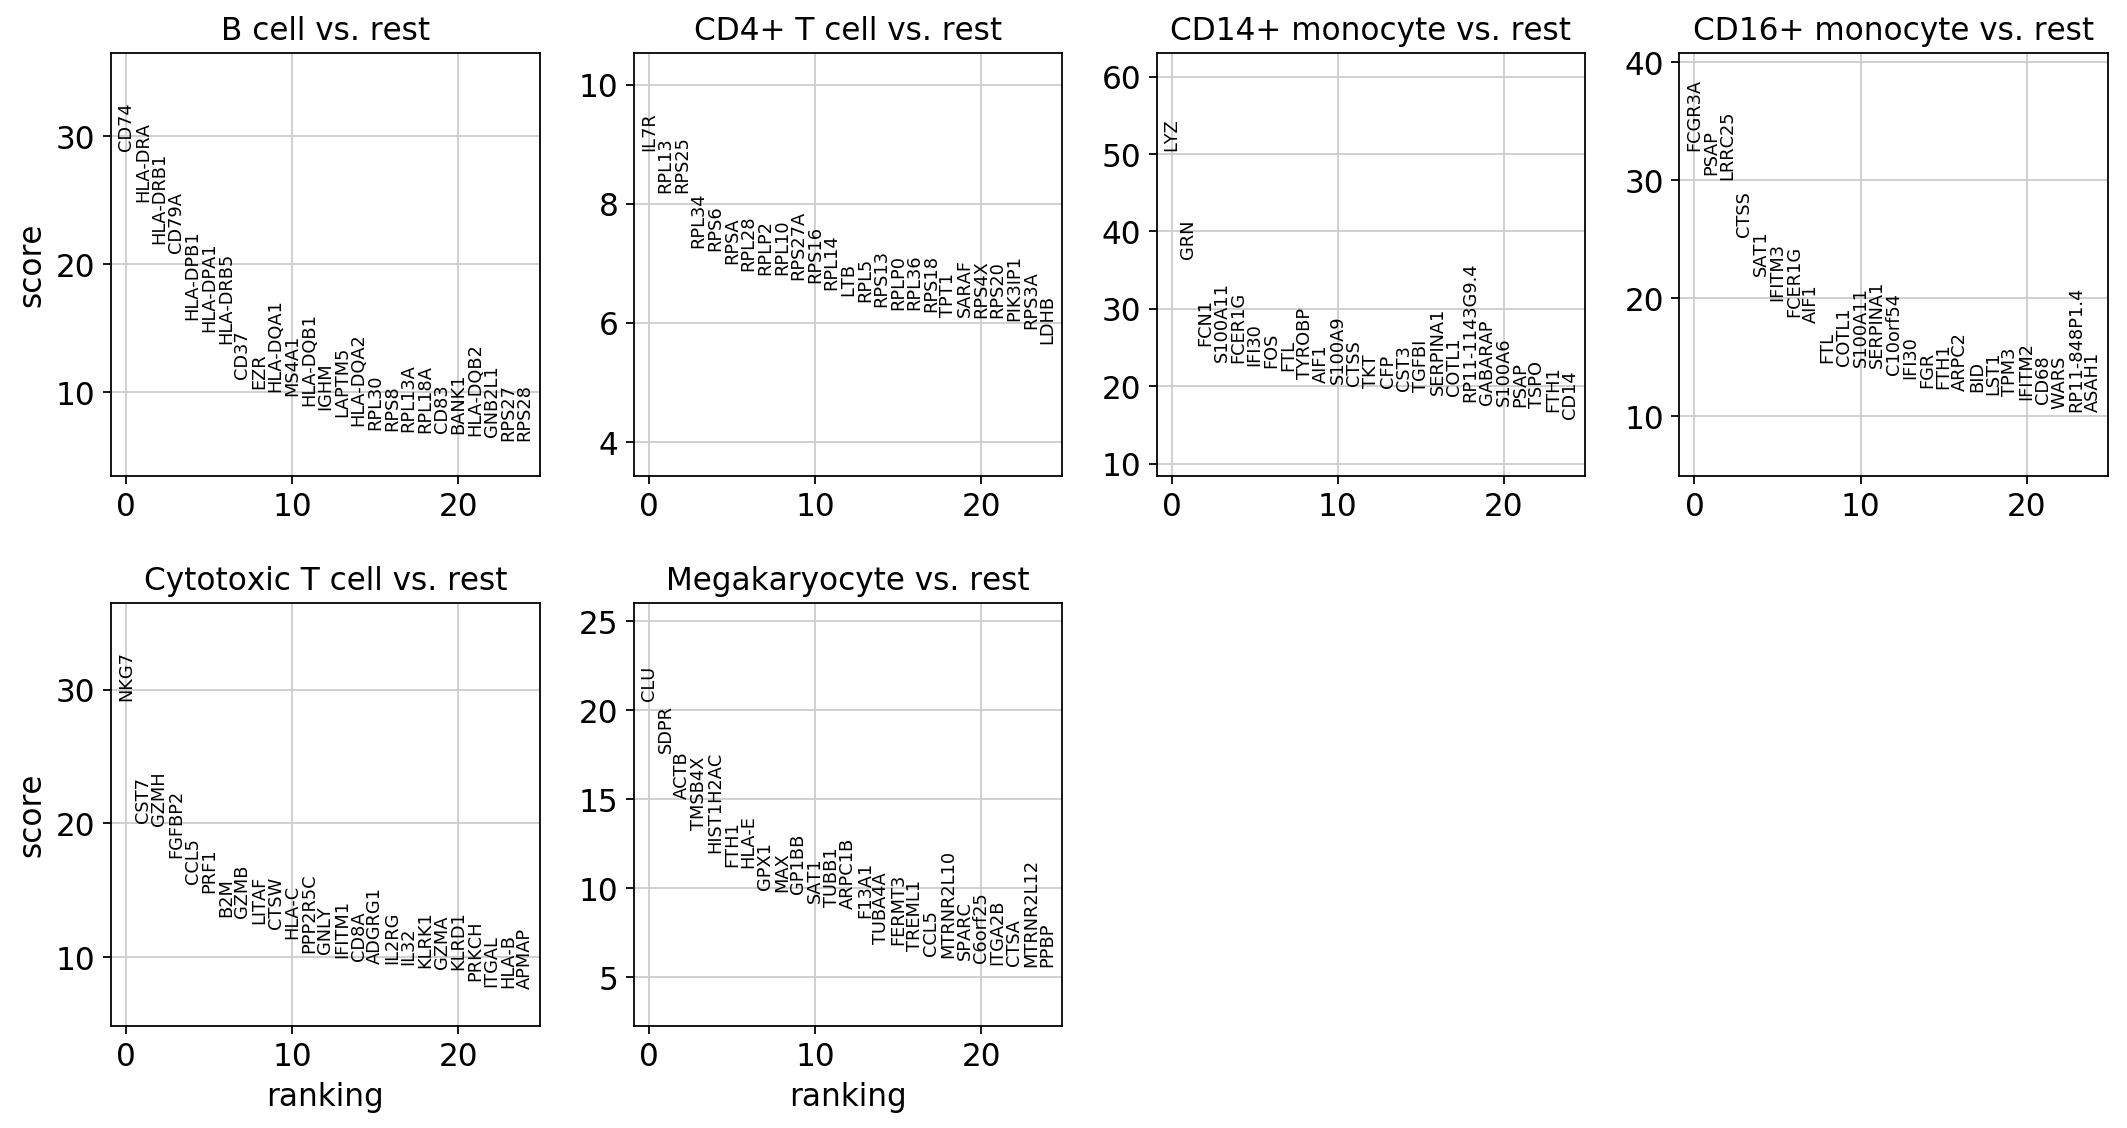

In [115]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [116]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
adata = sc.read(results_file)

In [117]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,B cell,CD4+ T cell,CD14+ monocyte,CD16+ monocyte,Cytotoxic T cell,Megakaryocyte
0,CD74,IL7R,LYZ,FCGR3A,NKG7,CLU
1,HLA-DRA,RPL13,GRN,PSAP,CST7,SDPR
2,HLA-DRB1,RPS25,FCN1,LRRC25,GZMH,ACTB
3,CD79A,RPL34,S100A11,CTSS,FGFBP2,TMSB4X
4,HLA-DPB1,RPS6,FCER1G,SAT1,CCL5,HIST1H2AC


In [133]:
adata.obs['cell_type'].values.categories

Index(['B cell', 'CD4+ T cell', 'CD14+ monocyte', 'CD16+ monocyte',
       'Cytotoxic T cell', 'Megakaryocyte'],
      dtype='object')

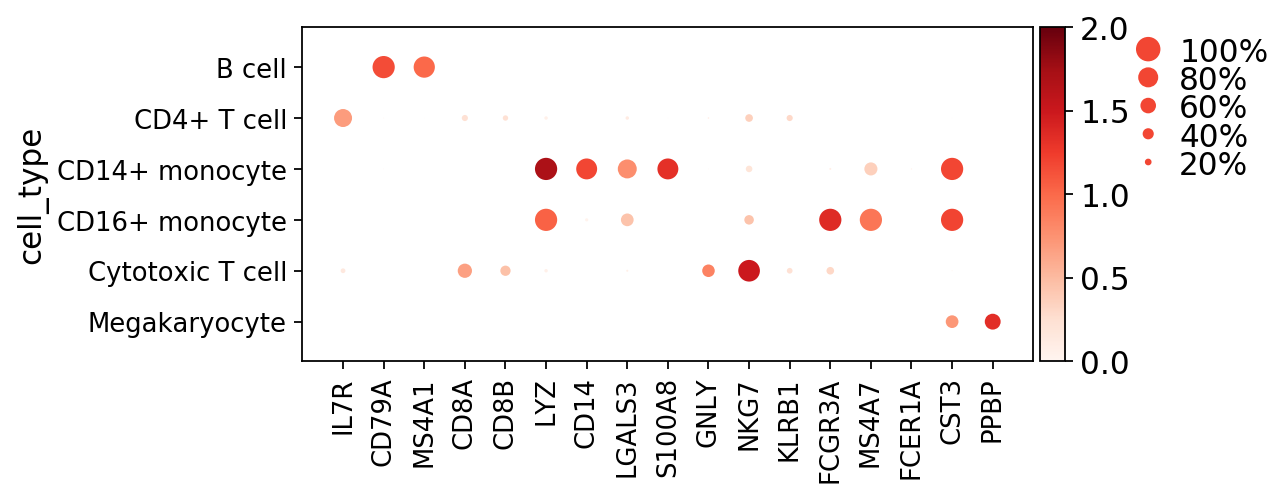

In [134]:
ax = sc.pl.dotplot(adata, marker_genes,
                   groupby='cell_type', save="_" + output_prefix + '.pdf',
                   log=True, expression_cutoff=0.1, vmax=2.0)

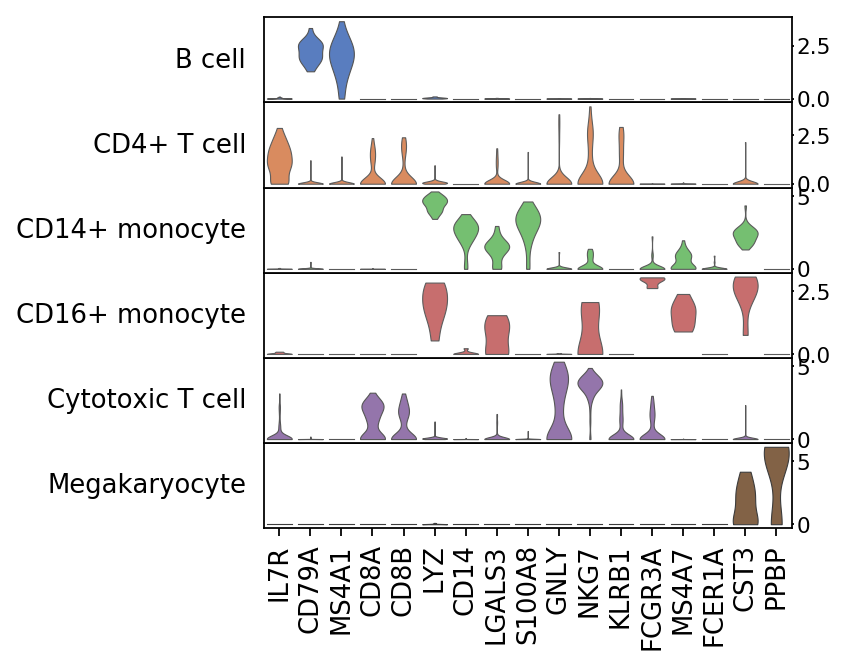

In [120]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='cell_type', rotation=90, save="_" + output_prefix + '.pdf')

In [ ]:
adata

In [ ]:
adata.write(results_file)